# Philadelphia: a city about to boom?

**Michael Uftring**   
**Indiana University**   
**I590 Data Visualization**   
**Fall, 2017**   


what is the purpose of this notebook?

The Change in Unemployment Rate over time with Unemployment Rate trend visualization creates a basic framework for assessment and comparison of cities. This approach will be used to establish the “Gold Standard” cities: those with the best numbers and trends, and perhaps sprinkle in less tangible qualities like general perception of being a “booming city.”



Establish the *Gold Standard* cities:
- Change in Unemployment Rate over time with Unemployment Rate trend visualization
- Industry and Occupation trends in these cities: what’s growing? what’s shrinking?


ToDo:

- load Top 100 cities
- extract list of cities
- generate BLS request for measureList = ["unemployment-rate"]


In [1]:
import requests
import json
import prettytable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import bls

%matplotlib inline

In [2]:
bls.init()

In [20]:
states = pd.read_csv("us-states.csv")

In [465]:
def stateCode(state):
    result = ""
    try:
        result = states[states.state==state].abbreviation.values[0]
    except:
        result = state
    return result

In [466]:
state = "Rhode Island"
stateCode(state)

'RI'

In [467]:
stateCode('RI')

'RI'

In [25]:
cities = pd.read_csv("us-cities-top100-cleaner.csv")

In [26]:
cities.head()

,Unnamed: 0,rank,city,statename,population_2016,population_2010,latitide,longitude,state
0,0,1,New York,New York,"8,537,673","8,175,133",﻿40.6635,-73.9387,NY
1,1,2,Los Angeles,California,"3,976,322","3,792,621",﻿34.0194,-118.4108,CA
2,2,3,Chicago,Illinois,"2,704,958","2,695,598",﻿41.8376,-87.6818,IL
3,3,4,Houston,Texas,"2,303,482","2,100,263",﻿29.7866,-95.3909,TX
4,4,5,Phoenix,Arizona,"1,615,017","1,445,632",﻿33.5722,-112.0901,AZ


In [27]:
cityName = 'St. Louis'
stateName = "MO"
bls.findCityTownCode(cityName, stateName)

['CT2965000000000']

In [38]:
df = cities[['city','state']].head()

In [39]:
df

,city,state
0,New York,NY
1,Los Angeles,CA
2,Chicago,IL
3,Houston,TX
4,Phoenix,AZ


In [43]:
cs = list(zip(df.city, df.state))

In [45]:
cs

[('New York', 'NY'),
 ('Los Angeles', 'CA'),
 ('Chicago', 'IL'),
 ('Houston', 'TX'),
 ('Phoenix', 'AZ')]

In [44]:
for c,s in cs:
    print("city: {} state: {}".format(c,s))

city: New York state: NY
city: Los Angeles state: CA
city: Chicago state: IL
city: Houston state: TX
city: Phoenix state: AZ


In [48]:
df = cities[['city','state']]
cityList = list(zip(df.city, df.state))

In [59]:
topN = 10
cityList[0:topN]

[('New York', 'NY'),
 ('Los Angeles', 'CA'),
 ('Chicago', 'IL'),
 ('Houston', 'TX'),
 ('Phoenix', 'AZ'),
 ('Philadelphia', 'PA'),
 ('San Antonio', 'TX'),
 ('San Diego', 'CA'),
 ('Dallas', 'TX'),
 ('San Jose', 'CA')]

In [60]:
len(cityList)

100

In [64]:
for city in cityList[0:topN]:
    print("city:",city)

city: ('New York', 'NY')
city: ('Los Angeles', 'CA')
city: ('Chicago', 'IL')
city: ('Houston', 'TX')
city: ('Phoenix', 'AZ')
city: ('Philadelphia', 'PA')
city: ('San Antonio', 'TX')
city: ('San Diego', 'CA')
city: ('Dallas', 'TX')
city: ('San Jose', 'CA')


In [65]:
startYear = 2008
endYear = 2017

dataSet = "LA"

seasonalAdjustment = "no"
if seasonalAdjustment == "yes":
    saCode = "S"
else:
    saCode = "U"

availableMeasures = ["labor-force", "employment", "unemployment", "unemployment-rate"]
measureList = ["unemployment-rate"]

colNames = ["seriesid","year","month","period","date","state","city","measure","value","footnotes"]

build and send requests, 10 cities at a time...

In [67]:
def buildSeriesIDs(cityList):
    seriesIDs = []
    for city,state in cityList:
        cityCode = bls.findCityTownCode(city,state)
        if len(cityCode) > 0:
            for measure in measureList:
                measureCode = bls.findMeasureCode(measure)
                seriesID = "{}{}{}{}".format(dataSet, saCode, cityCode[0], measureCode)
                #print("city: {} code: {} measure: {} code: {} seriesID: {}".format(city, cityCode, measure, measureCode, seriesID))
                seriesIDs.append(seriesID)
        else:
            print("Did not find City Code for {}".format(city))
    return seriesIDs

### request the data from the BLS

In [68]:
headers = {'Content-type': 'application/json'}
responses = []

count = 0
requestNumber = 0
segmentSize = 10
cityList2 = []
for city in cityList:
    count += 1
    cityList2.append(city)
    if count % segmentSize == 0:
        requestNumber += 1
        # construct Series IDs
        seriesIDs = buildSeriesIDs(cityList2)
        # build the request
        request = json.dumps({"seriesid": seriesIDs,"startyear":"{}".format(startYear), "endyear":"{}".format(endYear)})    
        # get the data using API
        print("Sending request {} ...".format(requestNumber))
        p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=request, headers=headers)
        # extract and save the response
        json_data = json.loads(p.text)
        responses.append(json_data)        
        cityList2 = []


Sending request 1 ...
Sending request 2 ...
Sending request 3 ...
Sending request 4 ...
Sending request 5 ...
Sending request 6 ...
Sending request 7 ...
Sending request 8 ...
Sending request 9 ...
Sending request 10 ...


In [69]:
len(responses)

10

### process the response from BLS

In [452]:
data = []
for json_data in responses:
    for series in json_data['Results']['series']:
        x=prettytable.PrettyTable(colNames)
        seriesId = series['seriesID']
        for item in series['data']:
            year = item['year']
            period = item['period']
            month = bls.code2month(period)
            date = bls.dateFrom(year, month)
            state = stateCode(bls.decodeState(seriesId))
            city = bls.trimCityName(bls.decodeCityTown(seriesId))
            measure = bls.decodeMeasure(seriesId)
            value = item['value']
            footnotes=""
            for footnote in item['footnotes']:
                if footnote:
                    footnotes = footnotes + footnote['text'] + ','
            if 'M01' <= period <= 'M12':
                row = [seriesId,year,month,period,date,state,city,measure,value,footnotes[0:-1]]
                x.add_row(row)
                data.append(row)

In [453]:
len(data)

11800

In [454]:
df = pd.DataFrame(data, columns=colNames)

In [455]:
df.head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
0,LAUCT365100000000003,2017,October,M10,2017/10,NY,New York,unemployment-rate,4.9,Preliminary.
1,LAUCT365100000000003,2017,September,M09,2017/09,NY,New York,unemployment-rate,5.0,
2,LAUCT365100000000003,2017,August,M08,2017/08,NY,New York,unemployment-rate,5.1,
3,LAUCT365100000000003,2017,July,M07,2017/07,NY,New York,unemployment-rate,5.0,
4,LAUCT365100000000003,2017,June,M06,2017/06,NY,New York,unemployment-rate,4.4,


In [456]:
len(df.city.unique())

100

In [457]:
# national unemployment rates are from here:
#   https://data.bls.gov/timeseries/LNS14000000

# manually create a dictionary; these are the July values for each year
nationalRates = {
    "2007": 4.7,
    "2008": 5.8,
    "2009": 9.5,
    "2010": 9.4,
    "2011": 9.0,
    "2012": 8.2,
    "2013": 7.3,
    "2014": 6.2,
    "2015": 5.2,
    "2016": 4.9,
    "2017": 4.3
}

nationalRateCurrent = nationalRates['2017']

In [458]:
nr = pd.DataFrame()
nr['measure'] = ['national rate'] * len(nationalRates.keys())
nr['year'] = list(nationalRates.keys())
nr['value'] = list(nationalRates.values())
t = nr.value.values.astype("float")
x = [j-i for i, j in zip(t[:-1], t[1:])]
nr['delta'] = [0] + x

In [459]:
nr

,measure,year,value,delta
0,national rate,2007,4.7,0.0
1,national rate,2008,5.8,1.1
2,national rate,2009,9.5,3.7
3,national rate,2010,9.4,-0.1
4,national rate,2011,9.0,-0.4
5,national rate,2012,8.2,-0.8
6,national rate,2013,7.3,-0.9
7,national rate,2014,6.2,-1.1
8,national rate,2015,5.2,-1.0
9,national rate,2016,4.9,-0.3


In [460]:
year = "2010"
nationalRates[year]

9.4

create a series for each city, in the series are the following data points:
- `city` : the city name
- `state`: the state abbreviation
- `beginYear`: the first year in the data set (it should be the same for all = 2008)
- `beginValue`: the city's unemployment rate for July of that first year
- `beginCTN`: the difference in the city's unemployment rate compared to the national unemployment rate
- `endYear`: the final year in the data set (it should be the same for all = 2017)
- `endValue`: the city's unemployment rate for July of that final year
- `endCTN`: the difference in the city's unemployment rate compared to the national unemployment rate
- `delta`: the difference in the city's unemployment rate from the first year to the final year

In [468]:
series = []
columns = ['city','state','begin_year','begin_value','begin_ctn','end_year','end_value','end_ctn','delta_value']
series.append(columns)

for city in df.city.unique():
    cd = df[(df.city==city) & (df.month=='July')].sort_values('year').copy()
    cd.drop(['seriesid','month','period','date','footnotes'], axis=1, inplace=True)
    state = stateCode(cd.head(1).state.values[0])
    beginYear = cd.head(1).year.values[0]
    beginValue = float(cd.head(1).value.values[0])
    beginCTN = beginValue - float(nationalRates[beginYear])
    endYear = cd.tail(1).year.values[0]
    endValue = float(cd.tail(1).value.values[0])
    endCTN = endValue - float(nationalRates[endYear])
    delta = endValue - beginValue
    series.append([city,state,beginYear,beginValue, beginCTN,endYear,endValue,endCTN,delta])

In [469]:
len(series)

101

In [470]:
series[0]

['city',
 'state',
 'begin_year',
 'begin_value',
 'begin_ctn',
 'end_year',
 'end_value',
 'end_ctn',
 'delta_value']

In [471]:
series[1:3]

[['New York',
  'NY',
  '2008',
  5.7,
  -0.09999999999999964,
  '2017',
  5.0,
  0.7000000000000002,
  -0.7000000000000002],
 ['Philadelphia',
  'PA',
  '2008',
  7.4,
  1.6000000000000005,
  '2017',
  6.9,
  2.6000000000000005,
  -0.5]]

create a DataFrame for the city series data

In [472]:
dfs = pd.DataFrame(series[1:], columns=series[0])

In [473]:
dfs.head()

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
0,New York,NY,2008,5.7,-0.1,2017,5.0,0.7,-0.7
1,Philadelphia,PA,2008,7.4,1.6,2017,6.9,2.6,-0.5
2,Phoenix,AZ,2008,6.7,0.9,2017,4.7,0.4,-2.0
3,San Jose,CA,2008,7.1,1.3,2017,4.2,-0.1,-2.9
4,Houston,TX,2008,5.0,-0.8,2017,4.7,0.4,-0.3


In [474]:
dfs.columns[0]

'city'

In [475]:
dfs.columns[1:]

Index(['state', 'begin_year', 'begin_value', 'begin_ctn', 'end_year',
       'end_value', 'end_ctn', 'delta_value'],
      dtype='object')

In [476]:
dfm = pd.melt(dfs,id_vars=dfs.columns[0], value_vars=dfs.columns[1:])

In [477]:
dfm.head()

,city,variable,value
0,New York,state,NY
1,Philadelphia,state,PA
2,Phoenix,state,AZ
3,San Jose,state,CA
4,Houston,state,TX


In [478]:
dfm[dfm.variable=='begin_year'].value.unique()

array(['2008'], dtype=object)

find the `TopN` greatest change in unemployment rate 

In [479]:
topN = 10
dfm[dfm.variable=='delta_value'].sort_values('value').head(topN)

,city,variable,value
720,Detroit,delta_value,-7.6
749,Oakland,delta_value,-4.8
763,Stockton,delta_value,-4.7
754,Santa Ana,delta_value,-4.4
796,San Bernardino,delta_value,-4.3
765,St. Louis,delta_value,-3.6
709,Los Angeles,delta_value,-3.5
751,Riverside,delta_value,-3.4
752,Aurora,delta_value,-3.4
777,Fort Wayne,delta_value,-3.4


Dertoit, MI has the largest change in unemployment rate when comparing before and after the great recession.

Let's take a closer look at Detroit, by the numbers..

In [480]:
cityName = 'Detroit'
month='July'
df[(df.city==cityName) & (df.month==month)].sort_values('year')[['city','state','year','measure','value']]

,city,state,year,measure,value
2471,Detroit,MI,2008,unemployment-rate,17.2
2459,Detroit,MI,2009,unemployment-rate,28.3
2447,Detroit,MI,2010,unemployment-rate,26.8
2435,Detroit,MI,2011,unemployment-rate,24.2
2423,Detroit,MI,2012,unemployment-rate,22.2
2411,Detroit,MI,2013,unemployment-rate,21.7
2399,Detroit,MI,2014,unemployment-rate,18.5
2387,Detroit,MI,2015,unemployment-rate,13.8
2375,Detroit,MI,2016,unemployment-rate,12.9
2363,Detroit,MI,2017,unemployment-rate,9.6


So, Detroit has had the greatest change in unemployment rate between 2008 and 2017. But, Detroit's unemployment rate is still much higher than the national rate. Look at Detroit's unemployment rate *during* the Great recession; it is almost 30% at its peak!

In [481]:
cityName = 'Detroit'
dfs[dfs.city==cityName]

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
20,Detroit,MI,2008,17.2,11.4,2017,9.6,5.3,-7.6


Looking at the series data for Detroit, we can see that pre-recession its unemployment rate was 11.4% higher than the national rate. And now, several years post-recession, Detroit's unemployment rate is 5.3% higher than the national rate.

Looking at the top 5 (or so) cities which have the greatest change in unemployment rate over the time span of data, we can see that all of these cities have much higher rates when compared to the national rate. These are not *booming* cities, these are cities which have historically had significant unemployment problems. However, it is worth noting that the economy and jobs are coming back to these "down" cities.

In [482]:
topN = 10
dfs.sort_values('delta_value').head(topN)

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
20,Detroit,MI,2008,17.2,11.4,2017,9.6,5.3,-7.6
49,Oakland,CA,2008,10.2,4.4,2017,5.4,1.1,-4.8
63,Stockton,CA,2008,12.9,7.1,2017,8.2,3.9,-4.7
54,Santa Ana,CA,2008,9.2,3.4,2017,4.8,0.5,-4.4
96,San Bernardino,CA,2008,11.8,6.0,2017,7.5,3.2,-4.3
65,St. Louis,MO,2008,8.4,2.6,2017,4.8,0.5,-3.6
9,Los Angeles,CA,2008,9.1,3.3,2017,5.6,1.3,-3.5
51,Riverside,CA,2008,9.4,3.6,2017,6.0,1.7,-3.4
52,Aurora,CO,2008,6.2,0.4,2017,2.8,-1.5,-3.4
77,Fort Wayne,IN,2008,6.8,1.0,2017,3.4,-0.9,-3.4


Let's take a more refined look at the data. Here we will find the cities with the best overall `delta value` (since before the recession), and are currently better than the current national rate.

In [483]:
dfs[dfs.end_ctn <= 0.0].sort_values('delta_value')

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
52,Aurora,CO,2008,6.2,0.4,2017,2.8,-1.5,-3.4
77,Fort Wayne,IN,2008,6.8,1.0,2017,3.4,-0.9,-3.4
56,Tampa,FL,2008,7.3,1.5,2017,4.2,-0.1,-3.1
18,Denver,CO,2008,5.4,-0.4,2017,2.4,-1.9,-3.0
79,St. Petersburg,FL,2008,6.8,1.0,2017,3.8,-0.5,-3.0
3,San Jose,CA,2008,7.1,1.3,2017,4.2,-0.1,-2.9
39,Colorado Springs,CO,2008,5.7,-0.1,2017,2.9,-1.4,-2.8
25,Nashville-Davidson (consolidated),TN,2008,5.7,-0.1,2017,3.0,-1.3,-2.7
90,Boise City,ID,2008,5.1,-0.7,2017,2.5,-1.8,-2.6
67,St. Paul,MN,2008,6.0,0.2,2017,3.6,-0.7,-2.4


Now sort by `end umemployment rate compared to the national rate`

In [484]:
# best compared to the current national rate
dfs[dfs.end_ctn <= 0.0].sort_values('end_ctn')

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
50,Honolulu,HI,2008,4.1,-1.7,2017,2.3,-2.0,-1.8
18,Denver,CO,2008,5.4,-0.4,2017,2.4,-1.9,-3.0
90,Boise City,ID,2008,5.1,-0.7,2017,2.5,-1.8,-2.6
86,Madison,WI,2008,3.5,-2.3,2017,2.5,-1.8,-1.0
78,Lincoln,NE,2008,3.2,-2.6,2017,2.7,-1.6,-0.5
52,Aurora,CO,2008,6.2,0.4,2017,2.8,-1.5,-3.4
39,Colorado Springs,CO,2008,5.7,-0.1,2017,2.9,-1.4,-2.8
14,Austin,TX,2008,4.4,-1.4,2017,3.0,-1.3,-1.4
25,Nashville-Davidson (consolidated),TN,2008,5.7,-0.1,2017,3.0,-1.3,-2.7
76,Irvine,CA,2008,4.3,-1.5,2017,3.1,-1.2,-1.2


One more look, this time by current unemployment rate `end_value`

In [485]:
better = len(dfs[dfs.end_value <= nationalRateCurrent].sort_values('end_value'))
number = 100
print("The national unemployment rate is {}%. There are {} cities in the Top {} that have an unemployment rate lower than or equal to the national rate.".format(nationalRateCurrent, better, number))

The national unemployment rate is 4.3%. There are 43 cities in the Top 100 that have an unemployment rate lower than or equal to the national rate.


In [486]:
dfs[dfs.end_value <= nationalRateCurrent].sort_values('end_value')

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
50,Honolulu,HI,2008,4.1,-1.7,2017,2.3,-2.0,-1.8
18,Denver,CO,2008,5.4,-0.4,2017,2.4,-1.9,-3.0
90,Boise City,ID,2008,5.1,-0.7,2017,2.5,-1.8,-2.6
86,Madison,WI,2008,3.5,-2.3,2017,2.5,-1.8,-1.0
78,Lincoln,NE,2008,3.2,-2.6,2017,2.7,-1.6,-0.5
52,Aurora,CO,2008,6.2,0.4,2017,2.8,-1.5,-3.4
39,Colorado Springs,CO,2008,5.7,-0.1,2017,2.9,-1.4,-2.8
14,Austin,TX,2008,4.4,-1.4,2017,3.0,-1.3,-1.4
25,Nashville-Davidson (consolidated),TN,2008,5.7,-0.1,2017,3.0,-1.3,-2.7
76,Irvine,CA,2008,4.3,-1.5,2017,3.1,-1.2,-1.2


What about **Philadelphia**?

In [487]:
cityName = 'Philadelphia'
month='July'

look at the `series` data to get a quick summary and the *compare to national* values

In [490]:
dfs[dfs.city==cityName]

,city,state,begin_year,begin_value,begin_ctn,end_year,end_value,end_ctn,delta_value
1,Philadelphia,PA,2008,7.4,1.6,2017,6.9,2.6,-0.5


and look at the "raw" data from **BLS** to see the unemployment rate for each year

In [492]:
cityData = df[(df.city==cityName) & (df.month==month)].sort_values('year')[['city','state','year','measure','value']]

In [509]:
cityData

,city,state,year,measure,value
229,Philadelphia,PA,2008,unemployment-rate,7.4
217,Philadelphia,PA,2009,unemployment-rate,10.3
205,Philadelphia,PA,2010,unemployment-rate,11.2
193,Philadelphia,PA,2011,unemployment-rate,11.7
181,Philadelphia,PA,2012,unemployment-rate,12.0
169,Philadelphia,PA,2013,unemployment-rate,11.0
157,Philadelphia,PA,2014,unemployment-rate,8.9
145,Philadelphia,PA,2015,unemployment-rate,8.0
133,Philadelphia,PA,2016,unemployment-rate,7.6
121,Philadelphia,PA,2017,unemployment-rate,6.9


In [533]:
c_years = cityData.year.values.astype("int")
c_values = cityData.value.values.astype("float")

In [534]:
n_years = nr.year.values[1:].astype("int")
n_values = nr.value.values[1:].astype("float")

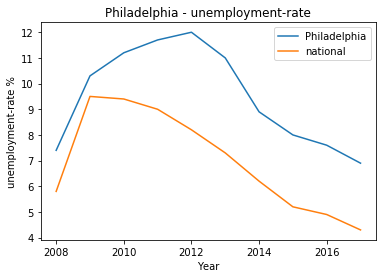

In [539]:
metric = measureList[0]
plt.plot(c_years, c_values, n_years, n_values)
plt.legend([cityName, 'national'])
plt.title("{} - {}".format(cityName, metric))
plt.xlabel("Year")
plt.ylabel("{} %".format(metric))

In [541]:
dfp = df[(df.city==cityName) & (df.month==month)].sort_values('year')[['city','state','year','measure','value']].copy()

In [542]:
t = dfp.value.values.astype("float")
x = [j-i for i, j in zip(t[:-1], t[1:])]
dfp['delta'] = [0] + x

In [543]:
# add the national rates to the DataFrame
# but skip the first entry because we don't have 2007 data for each city
dfp['national_year'] = nr.year.values[1:]
dfp['national_value'] = nr.value.values[1:]
dfp['national_delta'] = nr.delta.values[1:]
dfp['ctn'] = dfp.value.values.astype("float") - dfp.national_value.values.astype("float")

The change (delta) in `ctn` is an indicator of whether the city's unemployment rate is tracking the trend of the national rate. If the value is close to or equal to 0, then the two are trending the same. If the value is greater than 0, then the city is trending worse that the national rate. And if the value is less than zero, then the city is trending better than the national rate.

In [544]:
t = dfp.ctn.values.astype("float")
x = [j-i for i, j in zip(t[:-1], t[1:])]
dfp['delta_ctn'] = [0] + x

In [548]:
dfp[['city','state','year','value','delta','national_value','national_delta','ctn','delta_ctn']]

,city,state,year,value,delta,national_value,national_delta,ctn,delta_ctn
229,Philadelphia,PA,2008,7.4,0.0,5.8,1.1,1.6,0.0
217,Philadelphia,PA,2009,10.3,2.9,9.5,3.7,0.8,-0.8
205,Philadelphia,PA,2010,11.2,0.9,9.4,-0.1,1.8,1.0
193,Philadelphia,PA,2011,11.7,0.5,9.0,-0.4,2.7,0.9
181,Philadelphia,PA,2012,12.0,0.3,8.2,-0.8,3.8,1.1
169,Philadelphia,PA,2013,11.0,-1.0,7.3,-0.9,3.7,-0.1
157,Philadelphia,PA,2014,8.9,-2.1,6.2,-1.1,2.7,-1.0
145,Philadelphia,PA,2015,8.0,-0.9,5.2,-1.0,2.8,0.1
133,Philadelphia,PA,2016,7.6,-0.4,4.9,-0.3,2.7,-0.1
121,Philadelphia,PA,2017,6.9,-0.7,4.3,-0.6,2.6,-0.1


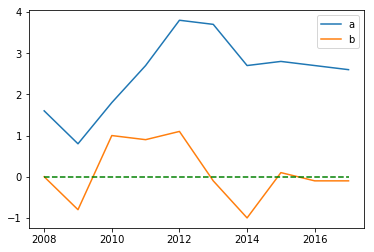

In [566]:
yrange = dfp.year.values.astype("int")


#plt.plot(yrange, dfp.value.values.astype("float"))
#plt.plot(yrange, dfp.national_value.values.astype("float"))
plt.plot(yrange, dfp.ctn.values.astype("float"), label='a')
plt.plot(yrange, dfp.delta_ctn.values.astype("float"), label='b')
plt.plot(yrange, [0]*len(yrange), "g--")
plt.legend()

In [324]:
def getNationalData():
    return nr[['year','value']][1:].sort_values('year').copy()

In [325]:
def getCityData(city):
    return df[(df.city==city) & (df.month=="July")].sort_values('year')[['year','value']].copy()

In [350]:
def computeColumnDelta(column):
    t = column.values.astype("float")
    return [0] + [j-i for i, j in zip(t[:-1], t[1:])]

In [351]:
def computeRowDelta(col1,col2):
    return col1.values.astype("float") - col2.values.astype("float")

In [381]:
city1 = "Philadelphia County/city"
city2 = "Austin city"

In [382]:
if city1 == "national":
    df1 = getNationalData()
else:
    df1 = getCityData(city1)

if city2 == "national":
    df2 = getNationalData()
else:
    df2 = getCityData(city2)

In [383]:
dfc = pd.DataFrame()
dfc['year'] = df1.year
dfc['national'] = nr.value.values[1:]
dfc['delta_national'] = computeColumnDelta(dfc.national)
dfc['value_1'] = df1.value.values
dfc['delta_1'] = computeColumnDelta(dfc.value_1)
dfc['value_2'] = df2.value.values
dfc['delta_2'] = computeColumnDelta(dfc.value_2)
dfc['comp_12'] = computeRowDelta(dfc.value_1,dfc.value_2)
dfc['delta_comp_12'] = computeColumnDelta(dfc.comp_12)

In [385]:
print("City 1: {}".format(city1))
print("City 2: {}".format(city2))
dfc

City 1: Philadelphia County/city
City 2: Austin city


,year,national,delta_national,value_1,delta_1,value_2,delta_2,comp_12,delta_comp_12
229,2008,5.8,0.0,7.4,0.0,4.4,0.0,3.0,0.000000e+00
217,2009,9.5,3.7,10.3,2.9,7.1,2.7,3.2,2.000000e-01
205,2010,9.4,-0.1,11.2,0.9,6.4,-0.7,4.8,1.600000e+00
193,2011,9.0,-0.4,11.7,0.5,6.3,-0.1,5.4,6.000000e-01
181,2012,8.2,-0.8,12.0,0.3,5.5,-0.8,6.5,1.100000e+00
169,2013,7.3,-0.9,11.0,-1.0,4.9,-0.6,6.1,-4.000000e-01
157,2014,6.2,-1.1,8.9,-2.1,4.1,-0.8,4.8,-1.300000e+00
145,2015,5.2,-1.0,8.0,-0.9,3.2,-0.9,4.8,-8.881784e-16
133,2016,4.9,-0.3,7.6,-0.4,3.3,0.1,4.3,-5.000000e-01
121,2017,4.3,-0.6,6.9,-0.7,3.0,-0.3,3.9,-4.000000e-01


Cities fixed:
- Washington, DC
- El Paso, TX
- St. Louis, MO
- Lexington, KY

Not sure:
- Long Beach, CA

ToDo:

- figure out how to verify city-town codes returned from `findCityTownCode` match the Top 100 City data values